In [1]:
import numpy as np 
import random
from scipy.linalg import orth
from sphere_decoding.new_sphereDecodingUseC import sphere_decoding_BER
import matplotlib.pyplot as plt
# from timeit import default_timer as time

# 交叉熵正常训练


Nt = 2
Nr = 4

iter_num = 30
channel_list = np.load("channel_list_4_2.npy")
H_list = channel_list[0:iter_num]
cov_list = np.load("covmatrix_list_4.npy")

SNR_list = np.array([0,4,8,12,16])


alpha = 0.05

# Adam
# beta1 = 0.8 
# beta2 = 0.999
# episilon = 1e-8

max_iter = 100

pilot_length = 128

beta1 = 0

SD_mean_performance = np.zeros(len(SNR_list))
SD_mean_performance_estimated = np.zeros(len(SNR_list))
QNN_mean_performance_128 = np.zeros(len(SNR_list))

save_loss = np.empty((len(SNR_list), iter_num))
save_BER = np.empty((len(SNR_list), iter_num))
save_channel = np.empty((len(SNR_list), iter_num, Nr, Nt), dtype=np.complex128)

In [2]:
# generate signals for simulation
def generate_random_bit_sequence(length):
    return ''.join(random.choice('01') for _ in range(length))

def qam16_modulation(binary_input):
    mapping = {
        '0000': (1+1j),
        '0001': (1+3j),
        '0010': (3+1j),
        '0011': (3+3j),
        '0100': (1-1j),
        '0101': (1-3j),
        '0110': (3-1j),
        '0111': (3-3j),
        '1000': (-1+1j),
        '1001': (-1+3j),
        '1010': (-3+1j),
        '1011': (-3+3j),
        '1100': (-1-1j),
        '1101': (-1-3j),
        '1110': (-3-1j),
        '1111': (-3-3j)
    }
    return mapping.get(binary_input, "Invalid binary input")/np.sqrt(10)

def generate_x_sequence(length, Nt):
    total_bits_sequence = generate_random_bit_sequence(length*Nt*4)
    bits_sequence = [total_bits_sequence[i:i+4] for i in range(0, len(total_bits_sequence), 4)]
    x_sequence = np.empty((Nt, length), dtype=np.complex128)
    for ii in range(length):
        x_sequence[:,ii] = [qam16_modulation(bits_sequence[ii*Nt+jj]) for jj in range(Nt)]
    return bits_sequence, x_sequence

def generate_channel(SNR):
    return np.sqrt(SNR)*H_list

def generate_covmatrix(dimension):
    U = orth(np.random.randn(dimension,dimension))
    x = np.random.rand(dimension)
    x = (x/np.sum(x))*dimension
    V = np.diag(x)
    whitening_matrix = np.dot(U, np.sqrt(V))
    cov_matrix = np.dot(whitening_matrix, whitening_matrix.conj().T)
    return cov_matrix

def generate_noise(cov_matrix,Nr):
    real_part = np.random.multivariate_normal(np.zeros(Nr), cov_matrix/2)
    imag_part = np.random.multivariate_normal(np.zeros(Nr), cov_matrix/2)
    return (real_part+1j*imag_part).reshape(Nr,1)

def generate_data(Nr,Nt,length,H_channel,cov_matrix):
    bits_sequence, x_sequence = generate_x_sequence(length, Nt)
    n_sequence = np.empty((length,Nr,1), dtype=np.complex128)
    for ii in range(length):
        n_sequence[ii] = generate_noise(cov_matrix,Nr)
    y_sequence = np.empty((Nr, length), dtype=np.complex128)
    for ii in range(length):
        s = np.dot(H_channel, x_sequence[:,ii].reshape(Nt,1))
        y_sequence[:, ii] = (s + n_sequence[ii]).reshape(Nr)
    return bits_sequence, x_sequence, y_sequence

def whiten_matrix(cov_matrix, H):
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    diagmatrix = np.sqrt(np.diag(eigenvalues))
    whitening_matrix = np.linalg.inv(np.dot(eigenvectors, diagmatrix))
    return np.dot(whitening_matrix, H)

In [3]:
# training H_hat

def bits2signals(bits):
    # bits: input binary string with length of (4*Nt) 
    return np.array([qam16_modulation(bits[i:i+4]) for i in range(0, len(bits), 4)]).reshape(Nt,1)

def calculate_layer1_training(H_hat, y):
    dimension_layer1 = 2**(4*Nt)
    # layer1 output
    error_norm = np.empty(dimension_layer1)
    output = np.empty(dimension_layer1)
    # calculate gradient components in layer1
    gradients = np.zeros((dimension_layer1, Nr, Nt), dtype=np.complex128)
    gradient_component = np.zeros((dimension_layer1, Nr, Nt), dtype=np.complex128)
    for index in range(dimension_layer1):
        bits = str(bin(index)[2:].zfill(4*Nt))
        s = bits2signals(bits)
        # s_conjugate_transpose = s.conj().T
        y = y.reshape(Nr, 1)
        error = y - np.dot(H_hat,s)
        error_norm[index] = np.square(np.linalg.norm(error))
        gradient_component[index] = np.dot(error, s.conj().T)

    min_error_norm = np.min(error_norm)

    for index in range(dimension_layer1):
        value =  np.exp(-error_norm[index]+min_error_norm)
        output[index] = value
        gradients[index] = -value*(-gradient_component[index])
    # print(output)
    return output, gradients


def layer2_matrix(n):
    if n == 1:
        return np.array([0,1])
    else:
        last_ = layer2_matrix(n-1)
        half_cols_num = 2**(n-1)
        first_row = np.concatenate((np.zeros(half_cols_num), np.ones(half_cols_num)))
        remain_rows = np.hstack((last_, last_))
        # print(remain_rows)
        return np.vstack((first_row, remain_rows))


def calculate_layer2_training(layer1_output, true_output):
    total_prob = np.sum(layer1_output)
    # print(total_prob)
    A = layer2_matrix(4*Nt)
    sum_prob_1 = np.dot(A, layer1_output)
    # layer2 output
    output = sum_prob_1/total_prob
    # calculate gradient components in layer2
    gradients = np.zeros(2**(4*Nt))
    # print(output)
    epsilon = 1e-10  # 为了防止log(0)的情况，添加一个小的常数
    output = np.clip(output, epsilon, 1. - epsilon)
    for ii in range(len(gradients)):
        # gradient1 = true_output/output
        # gradient2 = (np.ones(len(true_output))-true_output)/(np.ones(len(output))-output)
        for jj in range(4*Nt):
            gradient1 = true_output[jj]/output[jj]
            gradient2 = (1-true_output[jj])/(1-output[jj])
            gradient3 = A[jj][ii]/total_prob
            gradient4 = sum_prob_1[jj]/np.square(total_prob)
            # gradients for cross entropy
            gradients[ii] += (-1/(4*Nt))*(gradient1-gradient2)*(gradient3-gradient4)
            # gradients for MSE
            # gradients[ii] += (1/(4*Nt))*2*(output[jj]-true_output[jj])*(gradient3-gradient4)

    return output, gradients


def calculate_square_error(layer2_output, true_sequence):
    return np.linalg.norm(layer2_output-true_sequence)**2

def calculate_cross_entropy(layer2_output, true_sequence):
    epsilon = 1e-10  # 为了防止log(0)的情况，添加一个小的常数
    layer2_output = np.clip(layer2_output, epsilon, 1. - epsilon)
    cross_entropy = -np.mean(true_sequence * np.log(layer2_output) + (1 - true_sequence) * np.log(1 - layer2_output))
    return cross_entropy


def calculate_cost_function(H_hat):
    total_loss = 0
    total_gradients = np.zeros((Nr,Nt), dtype=np.complex128)
    training_length = len(y_sequence[0])
    for ii in range(training_length):
        # print(ii)
        true_sequence = ''.join(bits_sequence[ii*Nt+jj] for jj in range(Nt))
        true_sequence = np.array([eval(ii) for ii in true_sequence])
        layer1_output, layer1_gradients = calculate_layer1_training(H_hat, y_sequence[:, ii])
        layer2_output, layer2_gradients = calculate_layer2_training(layer1_output, true_sequence)
        total_loss += calculate_cross_entropy(layer2_output,true_sequence)
        # SGD
        if np.random.rand() < 0.9:
            for jj in range(2**(4*Nt)):
                total_gradients += (layer2_gradients[jj]*layer1_gradients[jj])
    mean_loss = total_loss/training_length
    return mean_loss, total_gradients


def training(max_iter):
    H_hat = np.sqrt(1/2)*(np.random.randn(Nr,Nt)+1j*np.random.randn(Nr,Nt))
    # H_hat = np.zeros((Nr,Nt), dtype=np.complex128)
    # H_hat = np.copy(H_estimated)
    momentum = np.zeros((Nr,Nt),dtype=np.complex128)
    last_loss = -100
    mean_loss = -200
    m = np.zeros((Nr,Nt),dtype=np.complex128)
    v = np.zeros((Nr,Nt))
    for iter_num in range(max_iter):
        # solve the gradient
        mean_loss, total_gradients = calculate_cost_function(H_hat)
        print("loss: "+str(mean_loss))
        if np.abs(last_loss-mean_loss) < 1e-4:
            return H_hat, mean_loss
        else:
            last_loss = mean_loss

        # update H_hat
        momentum = (1-beta1)*total_gradients + beta1*momentum
        H_hat -= alpha * momentum

        # Adaptive momentum to update H_hat
        # m = beta1*m + (1-beta1)*total_gradients # update biased first moment estimate
        # gradients_square = np.abs(total_gradients)**2 # elementwise square of gradients matrix
        # v = beta2*v + (1-beta2)*gradients_square # update biased second raw moment estimate
        # m_hat = m/(1-beta1**(iter_num+1)) # compute bias-corrected first moment estimate
        # v_hat = v/(1-beta2**(iter_num+1)) # compute bias-corrected second raw moment estimate
        # print("v:"+str(np.sqrt(v_hat)))
        # H_hat -= alpha * m_hat / (np.sqrt(v_hat)+episilon) # update H_hat
        # print(H_hat)
    return H_hat, mean_loss


In [4]:
# testing QNN for detection
def calculate_layer1_testing(H_hat, y):
    dimension_layer1 = 2**(4*Nt)
    # layer1 output
    output = np.zeros(dimension_layer1)
    error_norm = np.empty(dimension_layer1)
    for index in range(dimension_layer1):
        bits = str(bin(index)[2:].zfill(4*Nt))
        s = bits2signals(bits)
        y = y.reshape(Nr,1)
        error = y - np.dot(H_hat,s)
        error_norm[index] = np.square(np.linalg.norm(error))

    min_error_norm = np.min(error_norm)

    for index in range(dimension_layer1):
        value =  np.exp(-error_norm[index]+min_error_norm)
        output[index] = value
    return output


def calculate_layer2_testing(layer1_output):
    total_prob = np.sum(layer1_output)
    # print(total_prob)
    A = layer2_matrix(4*Nt)
    sum_prob_1 = np.dot(A, layer1_output)
    # layer2 output
    output = np.array([sum_prob_1[ii]/total_prob for ii in range(4*Nt)])
    return output

def detection(y, H_trained):
    layer1_output = calculate_layer1_testing(H_trained, y)
    layer2_output = calculate_layer2_testing(layer1_output)
    detect_result = ''
    for ii in range(len(layer2_output)):
        if(layer2_output[ii]>0.5):
            detect_result += '1'
        else:
            detect_result += '0'
    return(detect_result)

def count_differences(str1, str2):
    return sum(a != b for a, b in zip(str1, str2))

def calculate_BER(H_trained, bits_sequence_testing, y_sequence_testing):
    error = 0
    for ii in range(len(y_sequence_testing[0])):
        detect_result = detection(y_sequence_testing[:,ii], H_trained)
        true_sequence = ''.join(bits_sequence_testing[ii*Nt+jj] for jj in range(Nt))
        error += count_differences(detect_result, true_sequence)
    BER = error/(len(y_sequence_testing[0])*len(detect_result))
    return BER

In [7]:
for ii in range(len(SNR_list)):
    SNR_dB = SNR_list[ii]
    SNR = 10**(SNR_dB / 10)
    
    SD_performance = np.zeros(iter_num)
    SD_performance_estimated = np.zeros(iter_num)
    QNN_performance_128 = np.zeros(iter_num)

    for jj in range(iter_num):
        print("----------------------------current SNR_dB: " +str(SNR_dB))
        print("----------------------------current iter num: " +str(jj))

        H = H_list[jj] * np.sqrt(SNR)
        cov = cov_list[0]
        # cov = np.eye(Nr)

        bits_sequence_testing, x_sequence_testing, y_sequence_testing = generate_data(Nr,Nt,1024,H,cov)
        bits_sequence, x_sequence, y_sequence = generate_data(Nr,Nt,pilot_length,H,cov)
        H_estimated = np.dot(y_sequence, np.linalg.pinv(x_sequence))
        # print("估计信道")
        # print(H_estimated)

        # SD_performance[jj] = sphere_decoding_BER(H, y_sequence_testing, bits_sequence_testing, 1)
        # print("SD (perfect CSI): "+str(SD_performance[jj]))


        SD_performance_estimated[jj] = sphere_decoding_BER(H_estimated, y_sequence_testing, bits_sequence_testing, 100000)
        print("SD (estimated CSI): "+str(SD_performance_estimated[jj]))

        H_w = whiten_matrix(cov, H)
        # print("白化信道")
        # print(H_w)

        H_trained, loss = training(max_iter)
        BER = calculate_BER(H_trained, bits_sequence_testing, y_sequence_testing)

        # print("真实信道")
        # print(H)
        # print("QNN信道")
        # print(H_trained)
        # print("白化信道")
        # print(H_w)
        

        # save_BER[ii][jj] = BER

        QNN_performance_128[jj] = BER
        print("QNN: "+str(BER))

    # SD_mean_performance[ii] = np.mean(SD_performance)
    SD_mean_performance_estimated[ii] = np.mean(SD_performance_estimated)
    QNN_mean_performance_128[ii] = np.mean(QNN_performance_128)

----------------------------current SNR_dB: 0
----------------------------current iter num: 0
SD (estimated CSI): 0.1846923828125
loss: 2.100889863611202
loss: 0.9503643386496824
loss: 1.016722793730889
loss: 0.481412932256079
loss: 0.3341971174717855
loss: 0.3140032960035448
loss: 0.30353676224327664
loss: 0.2961837833225298
loss: 0.2906025631884666
loss: 0.28661651219321443
loss: 0.2838448467828515
loss: 0.28107542074245423
loss: 0.2792787385282996
loss: 0.27733561717266614
loss: 0.27602814765707573
loss: 0.2747692326871205
loss: 0.2734137344681405
loss: 0.2722415625300117
loss: 0.2712203402954631
loss: 0.2706669846288199
loss: 0.2700854757185876
loss: 0.269411737286479
loss: 0.26874618616997353
loss: 0.2682829691792162
loss: 0.2678319010713694
loss: 0.26758062682517164
loss: 0.26699744153808214
loss: 0.2666379606619592
loss: 0.26655677080759355
QNN: 0.1268310546875
----------------------------current SNR_dB: 0
----------------------------current iter num: 1
SD (estimated CSI): 0.297

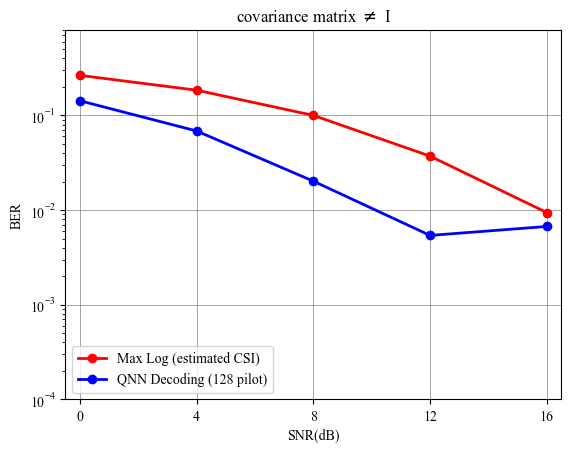

In [11]:
fig = plt.figure()
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Times New Roman']

ax1 = fig.add_subplot(111)

lns1 = ax1.plot(SNR_list, SD_mean_performance_estimated, '-ro', linewidth=2.0, label="Max Log (estimated CSI)")
lns2 = ax1.plot(SNR_list, QNN_mean_performance_128, '-bo', linewidth=2.0, label="QNN Decoding (128 pilot)")



lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="lower left")

# ax1.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs='auto'))
# ax1.grid(which='major', linestyle='-', linewidth='0.5', color='black')
# ax1.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

plt.grid(color='gray', linestyle='-', linewidth=0.5)

ax1.set_xticks(SNR_list)
ax1.set_yscale("log")
ax1.set_adjustable("datalim")
ax1.set_xlim(-0.5,16.5)
ax1.set_ylim(1e-4, 0.8)
ax1.set_ylabel("BER")
ax1.set_xlabel("SNR(dB)")
plt.title(r"covariance matrix $\neq$ I")

# plt.savefig('BER.png',dpi=600, bbox_inches='tight')
plt.show()